In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the dataset
file_path = '/content/drive/MyDrive/Dataset of Air quality index/air_pollution.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(data.info())
print("\nFirst 5 Rows of Data:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           432 non-null    object 
 1   pollutant      432 non-null    object 
 2   concentration  410 non-null    float64
dtypes: float64(1), object(2)
memory usage: 10.3+ KB
None

First 5 Rows of Data:
         date pollutant  concentration
0  2017-01-01        CO          0.561
1  2017-02-01        CO          0.530
2  2017-03-01        CO          0.589
3  2017-04-01        CO          0.662
4  2017-05-01        CO            NaN


In [5]:

# Check for missing values
print("\nMissing Values in Each Column:")
print(data.isnull().sum())


Missing Values in Each Column:
date              0
pollutant         0
concentration    22
dtype: int64


In [6]:
# Fill missing values in 'concentration' with the column mean
data['concentration'] = data['concentration'].fillna(data['concentration'].mean())

"""#Aggregate Pollutant Data"""

# Group data by date and compute average concentration for each pollutant
aggregated_data = data.groupby(['date', 'pollutant'])['concentration'].mean().reset_index()

print("\nAggregated Data:")
print(aggregated_data.head())


Aggregated Data:
         date pollutant  concentration
0  2017-01-01        CO       0.561000
1  2017-01-01       NO2       0.007600
2  2017-01-01        O3       0.015000
3  2017-01-01     PM 10      38.000000
4  2017-01-01    PM 2.5       6.349193


In [7]:
# Save the cleaned and aggregated dataset
output_path = '/content/drive/MyDrive/processed_air_pollution.csv'  # Replace with your desired path
aggregated_data.to_csv(output_path, index=False)

print(f"Processed dataset saved to {output_path}")

Processed dataset saved to /content/drive/MyDrive/processed_air_pollution.csv


In [8]:
# Summary statistics for the dataset
print("\nSummary Statistics:")
print(data.describe(include='all'))


Summary Statistics:
              date pollutant  concentration
count          432       432     432.000000
unique          72         6            NaN
top     2017-01-01        CO            NaN
freq             6        72            NaN
mean           NaN       NaN       6.349193
std            NaN       NaN       9.998311
min            NaN       NaN       0.000900
25%            NaN       NaN       0.006875
50%            NaN       NaN       0.505500
75%            NaN       NaN      12.337500
max            NaN       NaN      64.110000


In [9]:
# Check unique pollutants
unique_pollutants = data['pollutant'].unique()
print("\nUnique Pollutants:", unique_pollutants)

# Count of entries per pollutant
pollutant_counts = data['pollutant'].value_counts()
print("\nPollutant Counts:")
print(pollutant_counts)



Unique Pollutants: ['CO' 'NO2' 'O3' 'PM 10' 'PM 2.5' 'SO2']

Pollutant Counts:
pollutant
CO        72
NO2       72
O3        72
PM 10     72
PM 2.5    72
SO2       72
Name: count, dtype: int64


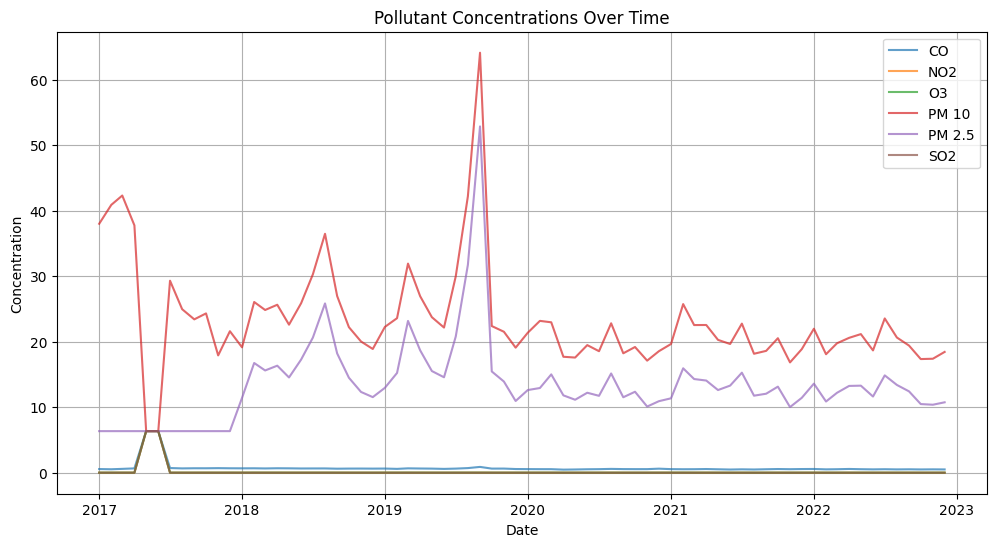

In [10]:

# Convert 'date' column to datetime format for proper handling
data['date'] = pd.to_datetime(data['date'])

# Plot pollutant concentration over time
plt.figure(figsize=(12, 6))
for pollutant in unique_pollutants:
    subset = data[data['pollutant'] == pollutant]
    plt.plot(subset['date'], subset['concentration'], label=pollutant, alpha=0.7)

plt.title('Pollutant Concentrations Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.show()

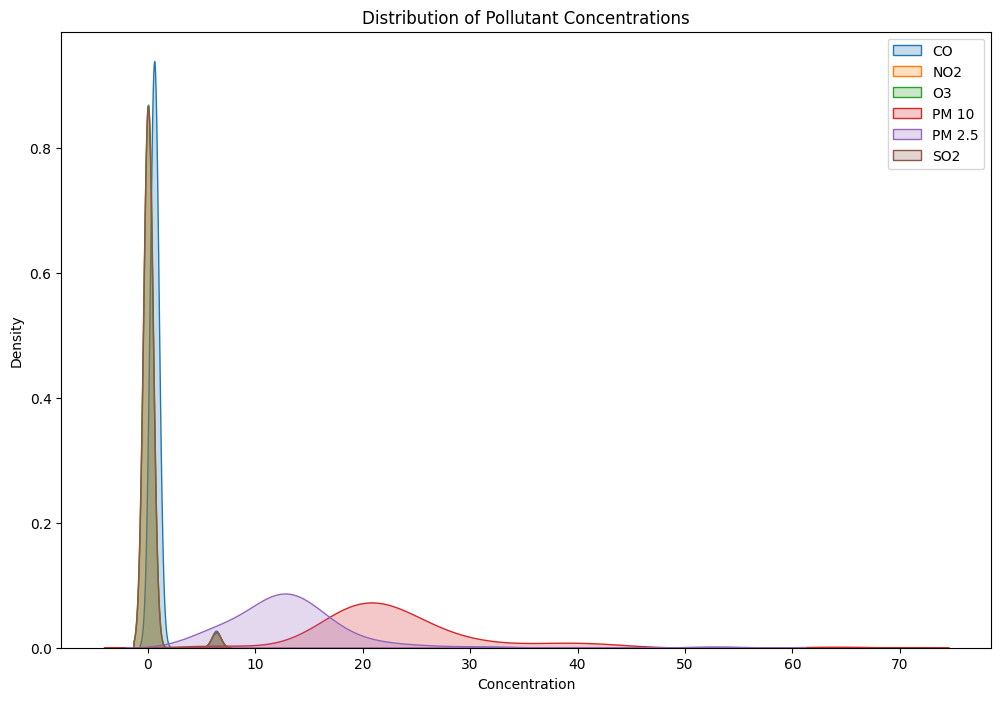

In [11]:
# Plot the distribution of concentration for each pollutant
plt.figure(figsize=(12, 8))
for pollutant in unique_pollutants:
    subset = data[data['pollutant'] == pollutant]
    sns.kdeplot(subset['concentration'], label=pollutant, fill=True)

plt.title('Distribution of Pollutant Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

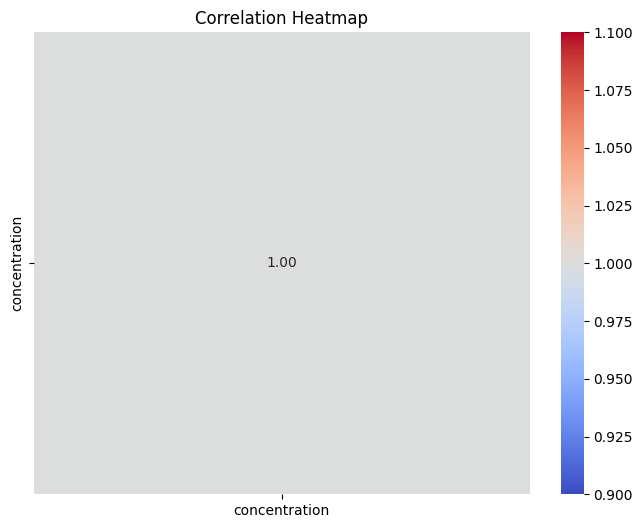

In [12]:
# Select only numeric columns for correlation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Check if numeric data is available
if not numeric_data.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.show()
else:
    print("No numeric columns available for correlation analysis.")

Feature Engineering

In [18]:
# Create additional time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Generate lag features for time-series analysis
data['lag_1'] = data['concentration'].shift(1)
data['lag_2'] = data['concentration'].shift(2)
data['rolling_mean_3'] = data['concentration'].rolling(window=3).mean()

# Drop rows with NaN values due to lag and rolling features
data = data.dropna()

print("\nData with Feature Engineering:")
print(data.head())



Data with Feature Engineering:
        date pollutant  concentration  year  month  day     lag_1     lag_2  \
4 2017-05-01        CO       6.349193  2017      5    1  0.662000  0.589000   
5 2017-06-01        CO       6.349193  2017      6    1  6.349193  0.662000   
6 2017-07-01        CO       0.716000  2017      7    1  6.349193  6.349193   
7 2017-08-01        CO       0.661000  2017      8    1  0.716000  6.349193   
8 2017-09-01        CO       0.682000  2017      9    1  0.661000  0.716000   

   rolling_mean_3  
4        2.533398  
5        4.453462  
6        4.471462  
7        2.575398  
8        0.686333  


Train and Split data

In [19]:
# Select features and target variable
X = data[['year', 'month', 'day', 'lag_1', 'lag_2', 'rolling_mean_3']]
y = data['concentration']

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training and Evaluation

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

Mean Absolute Error (MAE): 0.36
Mean Squared Error (MSE): 1.12


Prediction Visualization

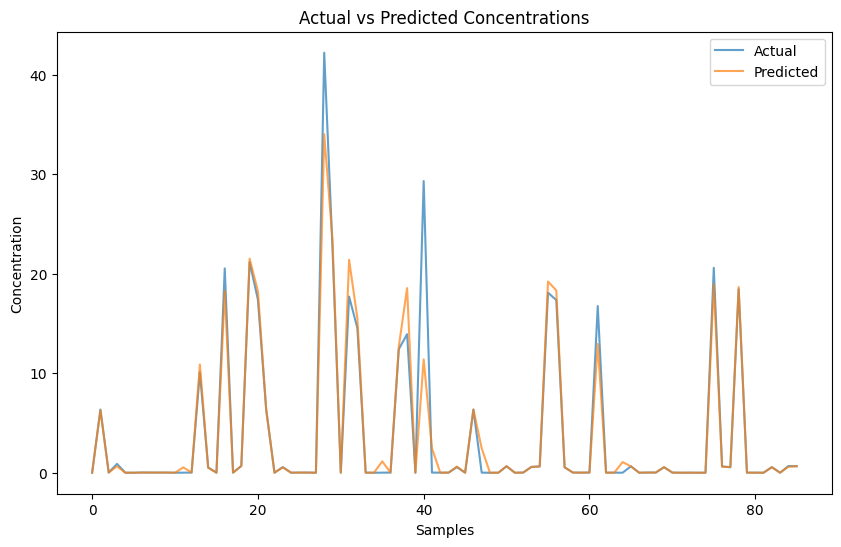

In [16]:
# Create a comparison DataFrame
comparison = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).reset_index(drop=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(comparison['Actual'], label='Actual', alpha=0.7)
plt.plot(comparison['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Concentrations')
plt.xlabel('Samples')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [ ]:
import joblib

# Save the model
model_path = '/content/drive/MyDrive/Dataset of Air quality index/air_pollution_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")